# Proyecto 04 - Informe Final Carrera

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

Recordemos que la serie de tiempo analizada en el proyecto anterior presentaba una tendencia negativa. Las hipotesis responsabilizaron a la concientizacion por el medio ambiente, o a que el incremento de los gastos relativos a la circulacion vehicular (nafta, seguros, peajes, etc) suele ser mayor a los incrementos del transporte publico. Otra opcion a la que se dio lugar, es que los usuarios simplemente estan organizandose para realizar car pooling (una moda ya implementada que crece con el paso del tiempo).

Por otro lado, es curioso, ya que segun lo investigado se puede observar como crece la cantidad de autos en circulacion y esto deberia reflejarse en una tendencia positiva, o al menos no tan negativa como la que se evidencio en el proyecto anterior, es por ello que se ampliara el alcance del proyecto 3, incorporando nuevos medios de pagos, demas estaciones y realizando un analisis exploratorio mas profundo.

### 1. Preparación del Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import pystan
from fbprophet import Prophet
from fbprophet.plot import plot_plotly

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import acf

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

ERROR:fbprophet.plot:Importing plotly failed. Interactive plots will not work.


# AED

In [2]:
data_2019 = pd.read_csv(r'C:\Users\manub\Documents\Datasets\flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv(r'C:\Users\manub\Documents\Datasets\flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv(r'C:\Users\manub\Documents\Datasets\flujo-vehicular-2017.csv', sep =',')

In [3]:
data_2019.forma_pago.unique()

array(['NO COBRADO', 'TELEPASE', 'EFECTIVO', 'EXENTO', 'INFRACCION',
       'T. DISCAPACIDAD'], dtype=object)

Se trabajara con todas las estaciones, y se incorporara el Telepase, ya que de todas las formas de pago posible es otra que contribuye al rendimiento economico de la empresa en analisis, excluyendo a las restantes ya que corresponden a infracciones o exenciones por distintas regulaciones.

In [4]:
# Unimos los 3
df = pd.concat([data_2019,data_2018,data_2017])

# Solo telepase y efectivo
df = df[(df.forma_pago == 'TELEPASE')^(df.forma_pago == 'EFECTIVO')]

#Quitamos las columnas que no vamos a utilizar
df.drop(columns = ['periodo','hora_inicio'], inplace = True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
df['fecha2'] = pd.to_datetime(df.fecha) + pd.to_timedelta(df.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
df.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
df.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reordenamos el dataset por fecha
df.sort_values('fecha', inplace = True)
df.reset_index(drop=True, inplace = True)

df.head()

,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha
0,Domingo,Dellepiane Liniers,Provincia,Pesado,TELEPASE,4,2017-01-01
1,Domingo,Avellaneda,Provincia,Pesado,TELEPASE,5,2017-01-01
2,Domingo,Avellaneda,Provincia,Pesado,EFECTIVO,7,2017-01-01
3,Domingo,Sarmiento,Provincia,Liviano,TELEPASE,17,2017-01-01
4,Domingo,Avellaneda,Provincia,Pesado,TELEPASE,3,2017-01-01


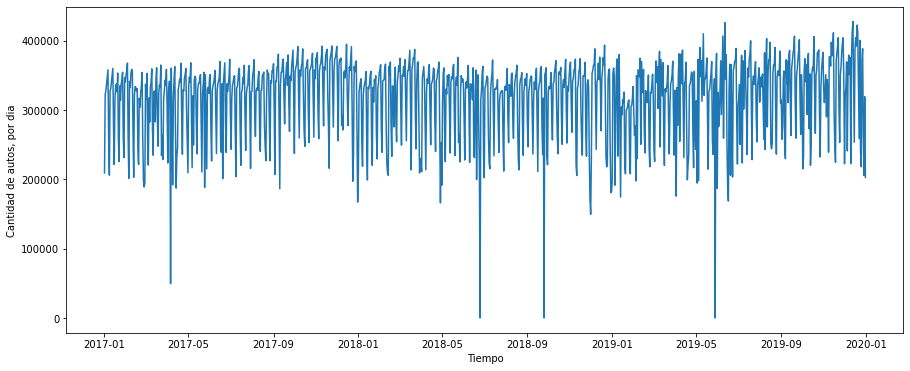

In [5]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = df.resample('D', on = 'fecha').sum()

plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

datasets:
- df (contiene toda la info, hasta discriminada por hora)
- diario

OUTLIERS

In [6]:
diario[diario.cantidad_pasos < 150000]

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


,cantidad_pasos
fecha,
2017-04-06,49595
2018-06-25,0
2018-09-25,0
2018-12-01,149695
2019-05-29,0


Paros:
- 06/04/17
- 25/06/18
- 25/09/18
- 29/05/19

G20:
- 01/12/18

Si bien, el 30/11/18 es el proximo dia al G20, hubo una circulacion de 171112 por lo que no se considerara como un valor extremo.

Voy a imputar el paso promedio segun el dia de la semana al que corresponde el valor extremo. Esto solo se hara para una correcta visualizacion por dia y analizar la tendencia, ya que para el modelo predictivo es necesario tener la informacion por estacion, lo que llevaria a imputar la ponderacion correspondiente a cada estacion del promedio calculado por dia, lo cual siguiendo un enfoque beneficio costo, no agregaria valor al modelo ya que solo son 3 dias que afectan significativamente el modelo (de 1095 dias, es decir, un 0.27%)

In [7]:
# Reseteo index
diario.reset_index(drop = False, inplace = True)

# Agrego el dia
diario['dia'] = diario['fecha'].dt.dayofweek

# Convierto el dia
def conversor_dia(dia):
    if dia == 0:
        return 'lunes'
    if dia == 1:
        return 'martes'
    if dia == 2:
        return 'miercoles'
    if dia == 3:
        return 'jueves'
    if dia == 4:
        return 'viernes'
    if dia == 5:
        return 'sabado'
    if dia == 6:
        return 'domingo'
diario['dia'] = diario['dia'].apply(lambda dia: conversor_dia(dia))

# Promedio por dia
promedio_por_dia = (diario.groupby(by = 'dia').mean()).round()

# Outliers
outliers = diario[diario.cantidad_pasos < 150000]

# Agrego columna promedio_por_dia para poder hacer el for
outliers = pd.merge(outliers, promedio_por_dia, how = 'left', left_on = 'dia', right_index = True)
outliers.rename(columns = {'cantidad_pasos_y':'promedio_por_dia'}, inplace = True)

# Imputo en diario
for x in outliers['fecha']:    
    diario['cantidad_pasos'].values[diario['fecha'] == x] = outliers[outliers['fecha'] == x]['promedio_por_dia']

print((diario.cantidad_pasos < 150000).sum()) 

0


NULLS

In [8]:
pd.isna(df).sum()

dia               0
estacion          0
sentido           0
tipo_vehiculo     0
forma_pago        0
cantidad_pasos    0
fecha             0
dtype: int64

No hay nulos, por lo tanto no se realizan ajustes

Pasamos a semanal

In [9]:
semanal = diario.resample(rule = "W", on = 'fecha').sum()

# eliminamos primera y ultima fila (es un dia, no una semana)
semanal.drop(index = [semanal.index[0],semanal.index[157]], inplace = True)

# calculamos la tendencia
tendencia_semanal = semanal['cantidad_pasos'].rolling(window = 4, center = True).mean()
tendencia_semanal = pd.DataFrame(tendencia_semanal)

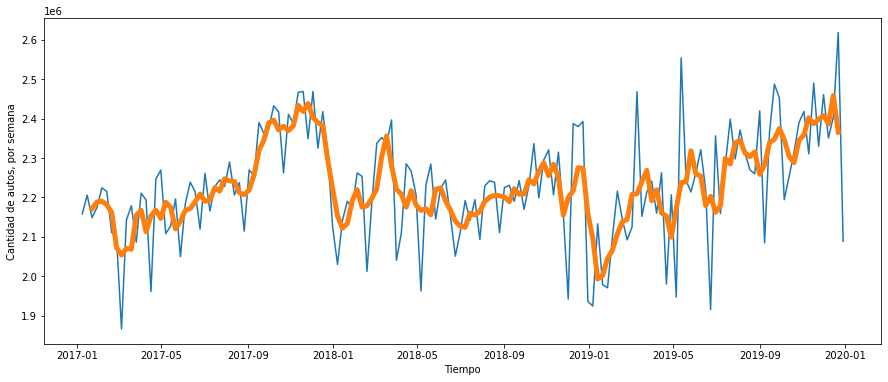

In [10]:
# Graficamos ambos
plt.figure(figsize = (15,6))
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.plot(tendencia_semanal.index, tendencia_semanal.cantidad_pasos, lw = 5)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.show()

Se caen las hipotesis mencionadas al principio del proyecto, se nota una clara tendencia positiva.

Por lo tanto seria logico pensar que esto se debe a que lo que disminuyo fue el pago en efectivo, con lo que llevo a que la gente abone con telepase

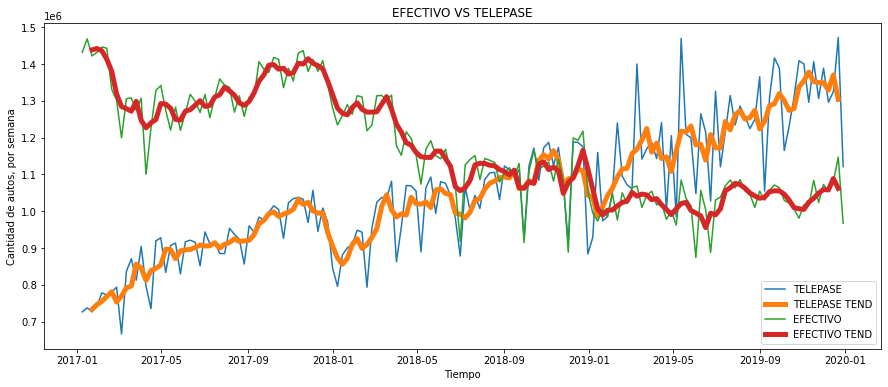

In [11]:
# Resampleo a semanal discriminado por medio de pago

semanal_telepase = df[df.forma_pago == 'TELEPASE'].resample(rule = "W", on = 'fecha').sum()
semanal_efectivo = df[df.forma_pago == 'EFECTIVO'].resample(rule = "W", on = 'fecha').sum()

# Eliminamos primer y ultima semana (1 solo dia)
semanal_telepase.drop(index = [semanal_telepase.index[0],semanal_telepase.index[157]], inplace = True)
semanal_efectivo.drop(index = [semanal_efectivo.index[0],semanal_efectivo.index[157]], inplace = True)

# Calculamos las tendencias

tendencia_semanal_telepase = semanal_telepase['cantidad_pasos'].rolling(window = 4, center = True).mean()
tendencia_semanal_telepase = pd.DataFrame(tendencia_semanal_telepase)

tendencia_semanal_efectivo = semanal_efectivo['cantidad_pasos'].rolling(window = 4, center = True).mean()
tendencia_semanal_efectivo = pd.DataFrame(tendencia_semanal_efectivo)

# Graficamos
plt.figure(figsize = (15,6))
plt.plot(semanal_telepase.index, semanal_telepase.cantidad_pasos, label = 'TELEPASE')
plt.plot(tendencia_semanal_telepase.index, tendencia_semanal_telepase.cantidad_pasos, lw = 5, label = 'TELEPASE TEND')

plt.plot(semanal_efectivo.index, semanal_efectivo.cantidad_pasos, label = 'EFECTIVO')
plt.plot(tendencia_semanal_efectivo.index, tendencia_semanal_efectivo.cantidad_pasos, lw = 5, label = 'EFECTIVO TEND')

plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.title('EFECTIVO VS TELEPASE')
plt.legend()
plt.show()

Confirmada la teoria sobre el cambio en la forma de pago

In [12]:
# Agregamos columnas claves para analisis

df['año'] = df.fecha.dt.year
df['mes'] = df.fecha.dt.month
df['numero_dia'] = df.fecha.dt.day
df['hora'] = df.fecha.dt.hour

In [13]:
# Agregaremos numeros a los dias de la semana para ordenarlos

dicc = {'Lunes':'0 Lunes',
        'Martes':'1 Martes',
        'Miércoles': '2 Miercoles',
        'Jueves': '3 Jueves',
        'Viernes': '4 Viernes',
        'Sábado': '5 Sabado',
        'Domingo': '6 Domingo'}

for x in dicc:
    df.dia.values[df.dia == x] = dicc.get(x)
df.head()

,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha,año,mes,numero_dia,hora
0,6 Domingo,Dellepiane Liniers,Provincia,Pesado,TELEPASE,4,2017-01-01,2017,1,1,0
1,6 Domingo,Avellaneda,Provincia,Pesado,TELEPASE,5,2017-01-01,2017,1,1,0
2,6 Domingo,Avellaneda,Provincia,Pesado,EFECTIVO,7,2017-01-01,2017,1,1,0
3,6 Domingo,Sarmiento,Provincia,Liviano,TELEPASE,17,2017-01-01,2017,1,1,0
4,6 Domingo,Avellaneda,Provincia,Pesado,TELEPASE,3,2017-01-01,2017,1,1,0


In [14]:
(df.groupby(by = 'estacion').sum()).sort_values(by = 'cantidad_pasos', ascending = False)

,cantidad_pasos,año,mes,numero_dia,hora
estacion,,,,,
Avellaneda,135383373,1091228417,3535222,8492158,6376884
Illia,98391659,894829956,2884991,6957016,5223601
Dellepiane Centro,29532693,442615663,1426680,3440873,2557589
Dellepiane,27795023,140728338,455386,1093984,802314
Dellepiane Liniers,27519638,428550978,1385522,3335960,2505830
Alberdi,10540269,314694914,1021486,2451490,1912908
Alberti,5281543,122016246,395930,949249,733437
Retiro,4757292,471907687,1504033,3664792,2780374
PDB,3462416,41294607,163925,342761,235839


Hay mucha diferencia entre las estaciones, por lo que se agruparan en 4 grupos:
1. Avellaneda
2. Illia
3. Dellepiane (las 3).
4. Resto

In [15]:
dicc = {'Dellepiane Centro':'Dellepiane',
        'Dellepiane Liniers':'Dellepiane',
        'Alberdi': 'Otras',
        'Alberti': 'Otras',
        'Retiro': 'Otras',
        'PDB': 'Otras',
        'Sarmiento': 'Otras',
        'Salguero' : 'Otras'}

for x in dicc:
    df.estacion.values[df.estacion == x] = dicc.get(x)

print(df.estacion.unique())

['Dellepiane' 'Avellaneda' 'Otras' 'Illia']


ANALISIS PROMEDIO DIA SEGUN ESTACION

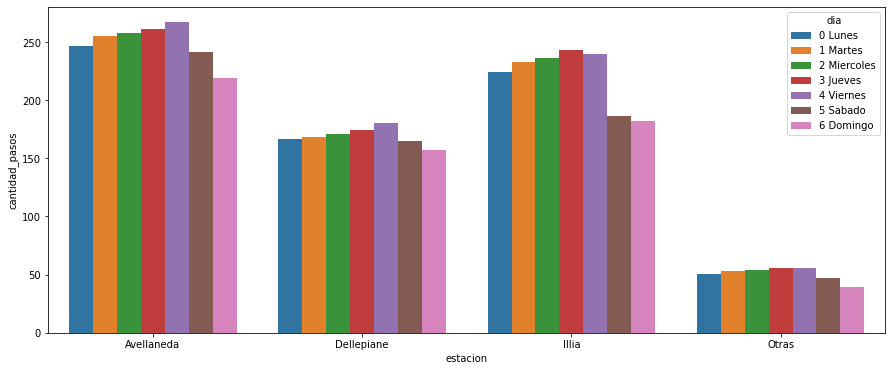

In [16]:
estacion_dia = df.groupby(by = ['estacion','dia']).mean()
estacion_dia.reset_index(drop = False, inplace = True)

plt.figure(figsize = (15,6))
sns.barplot(x = 'estacion' , y = 'cantidad_pasos', data = estacion_dia, hue = 'dia')
plt.show()

Todas las estaciones tienen un comportamiento distinto segun el dia de la semana. 

Se puede apreciar como Illia y Avellaneda que tienen mas cercania al Centro (donde se encuentran el sector empresarial) disminuyen su circulacion los fines de semana.

ANALISIS PROMEDIO HORA SEGUN ESTACION

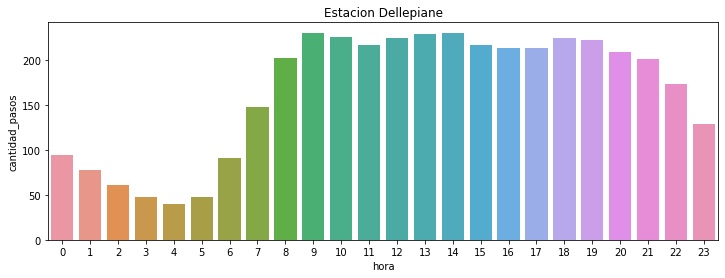

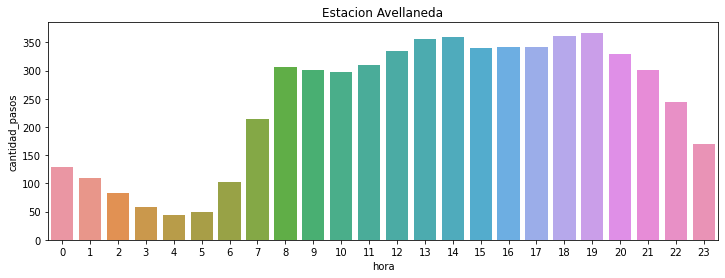

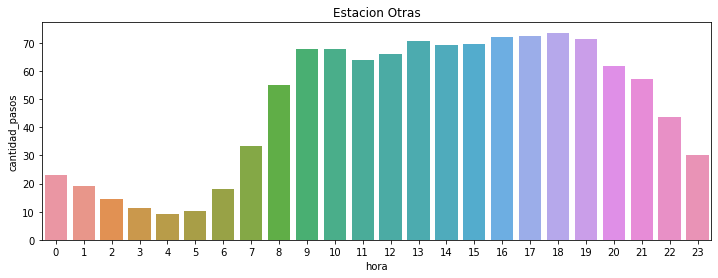

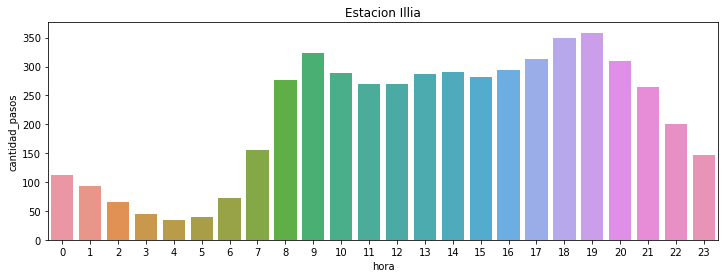

In [17]:
for x in df.estacion.unique():

    estacion_hora = df[df.estacion == x].groupby(by = ['hora']).mean()
    estacion_hora.reset_index(drop = False, inplace = True)

    plt.figure(figsize = (12,4))
    sns.barplot(x = 'hora', y = 'cantidad_pasos', data = estacion_hora)
    plt.title('Estacion {}'.format(x))
    plt.show()

Las cuatro categorias de estaciones presentan un patron similar para los horarios anteriores a las 8 am.

Lo interesante es como la estacion Illia, incrementa su circulacion en los horarios 9 y 18/19, mostrando que dichos picos estan relacionados con las jornadas laborales. Este patron tambien se presenta en las otras estaciones, pero en menor medida.

ANALISIS PROMEDIO MES SEGUN ESTACION

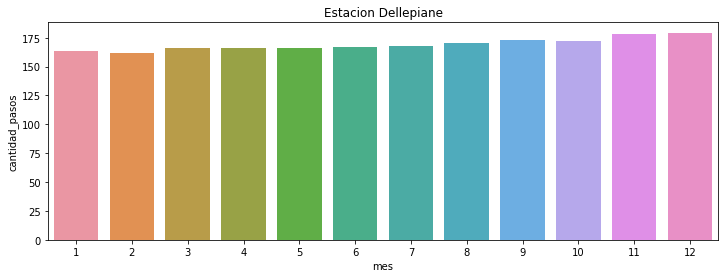

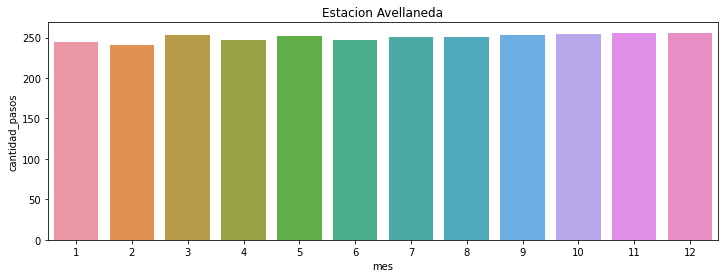

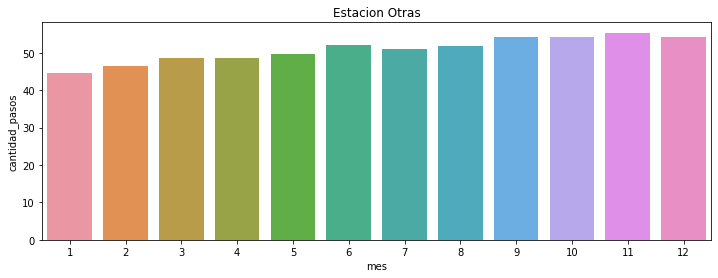

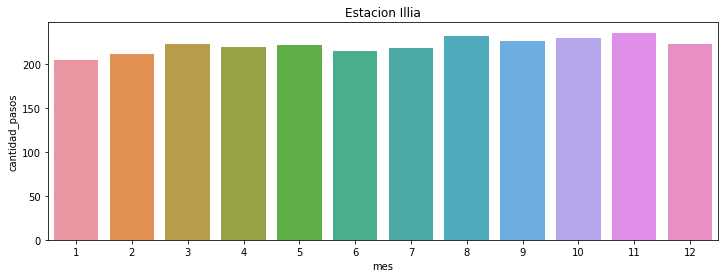

In [18]:
for x in df.estacion.unique():

    estacion_mes = df[df.estacion == x].groupby(by = ['mes']).mean()
    estacion_mes.reset_index(drop = False, inplace = True)

    plt.figure(figsize = (12,4))
    sns.barplot(x = 'mes', y = 'cantidad_pasos', data = estacion_mes)
    plt.title('Estacion {}'.format(x))
    plt.show()

- Todas presentan una disminucion en Enero y Febrero (Illia mas pronunciado que sus pares).
- En Illia tambien disminuye en diciembre, no pasando esto en sus pares, especialmente en Dellepiane y Avellaneda que curiosamente dicho mes se encuentra casi liderando el podio.

ANALISIS PROMEDIO AÑO SEGUN ESTACION

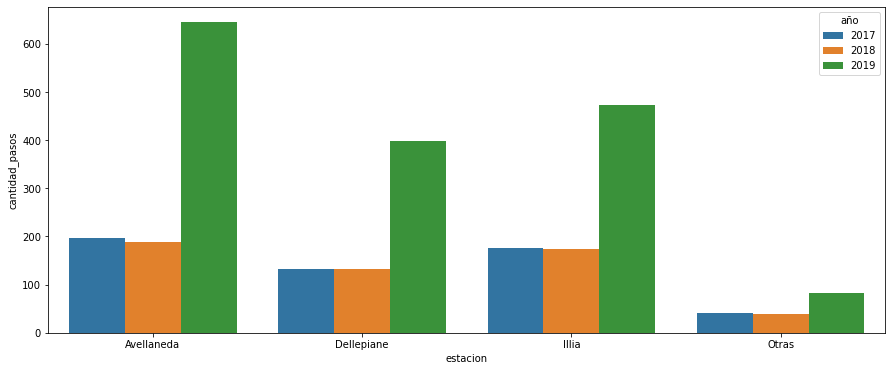

In [19]:
estacion_año = df.groupby(by = ['estacion','año']).mean()
estacion_año.reset_index(drop = False, inplace = True)

plt.figure(figsize = (15,6))
sns.barplot(x = 'estacion' , y = 'cantidad_pasos', data = estacion_año, hue = 'año')
plt.show()

Es extraño, porque en 2017 hay mas circulacion que en 2018. No se me ocurre otro factor a cual atribuirselo, que a la situacion economica que atraveso el pais en tales periodos, siendo mas conveniente manejarse en auto durante el 2017 que en el 2018. Por supuesto que por la tendencia creciente se nota como en 2019 crece en gran escala los pasos de los autos.

Por otro lado es interesante como en Illia dicho incremento fue en menor cuantia que sus pares, esto podria deberse a que considerando su cercania con la zona centrica sea un peaje que la gente gustaria evitar.

# MODELO PREDICTIVO

Benchmark - MODELO DE REGRESION LINEAL

RMSE del Benchmark: 62502.0


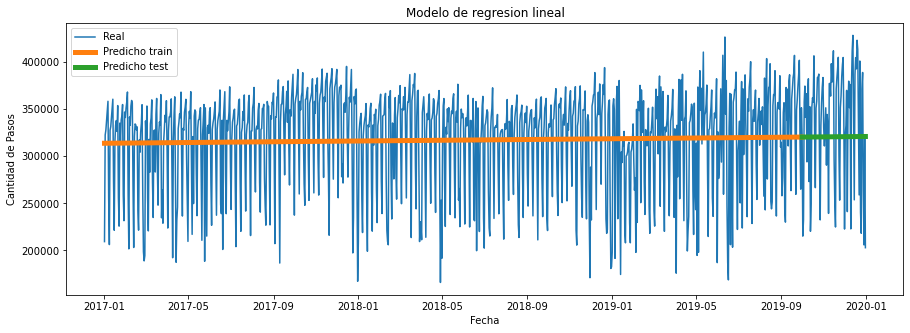

In [20]:
# Pasamos las fechas a numeros
diario['fecha_numeros'] = diario.fecha.map(datetime.datetime.toordinal)

# Train test split
split = '2019-09-30'
train = diario[diario.fecha <= split]
test = diario[diario.fecha > split]

X_train = train[['fecha_numeros']]
y_train = train[['cantidad_pasos']]

X_test = test[['fecha_numeros']]
y_test = test[['cantidad_pasos']]

# Creamos la regresion lineal
reg_lin = LinearRegression()
reg_lin.fit(X_train, y_train)

# Predecimos y calculamos el RMSE
y_pred = reg_lin.predict(X_test)
rmse_lineal = np.sqrt(mean_squared_error(y_test, y_pred)).round()
print('RMSE del Benchmark: {}'.format(rmse_lineal))

# Graficamos
plt.figure(figsize = (15,5))

plt.plot(diario.fecha, diario.cantidad_pasos, label = 'Real')
plt.plot(train.fecha, reg_lin.predict(X_train), label = 'Predicho train', lw = '5')
plt.plot(test.fecha, reg_lin.predict(X_test), label = 'Predicho test', lw = '5')

plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.title('Modelo de regresion lineal')
plt.legend()
plt.show()

Es logico que al incorporar nuevos datos se incremente el RMSE

In [21]:
# Dejamos listo el dataset para el analisis

df['fecha_numeros'] = df.fecha.map(datetime.datetime.toordinal)
df.drop(columns = ['fecha', 'año', 'mes', 'numero_dia', 'hora'], inplace = True)
df = pd.get_dummies(df)
df.head()

,cantidad_pasos,fecha_numeros,dia_0 Lunes,dia_1 Martes,dia_2 Miercoles,dia_3 Jueves,dia_4 Viernes,dia_5 Sabado,dia_6 Domingo,estacion_Avellaneda,estacion_Dellepiane,estacion_Illia,estacion_Otras,sentido_Centro,sentido_Provincia,tipo_vehiculo_Liviano,tipo_vehiculo_Pesado,forma_pago_EFECTIVO,forma_pago_TELEPASE
0,4,736330,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1
1,5,736330,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,1
2,7,736330,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0
3,17,736330,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,1
4,3,736330,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,1


In [22]:
# Train test split
split = datetime.date(2019,9,30).toordinal()

train = df[df.fecha_numeros <= split]
test  = df[df.fecha_numeros >  split]

X_train = train.drop(columns = 'cantidad_pasos')
y_train = train['cantidad_pasos']

X_test = test.drop(columns = 'cantidad_pasos')
y_test = test['cantidad_pasos']

In [24]:
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)

y_train_pred = random_forest.predict(X_train)
y_test_pred = random_forest.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred)).round()
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred)).round()

print('El RMSE de train es: {}'.format(rmse_train))
print('El RMSE de test es: {}'.format(rmse_test))

El RMSE de train es: 284.0
El RMSE de test es: 349.0


Es sorprendente como bajo el RMSE.

El principal responsable de la disminucion, es la inclusion de las variables categoricas, ya que ahora no es que se predice la circulacion para un dia en particular, sino que se predice la circulacion en determinada estacion, para cierto tipo de vehiculo, sentido, dia, etc, pudiendo ser mas preciso el entrenamiento por lo tanto tambien lo es la prediccion. (Ya que habia una varacion importante en el comportamiento de los datos segun las distintas categorias).

Se procedera a optimizar los hiperparametros para mejorar su rendimiento.

In [35]:
random_forest = RandomForestRegressor()

param_dist = {'n_estimators': [50, 100, 200],
             'max_features': np.arange(2,7),
             'n_jobs' : np.arange(3,6)}

model_random = RandomizedSearchCV(random_forest, param_distributions=param_dist,
                                  n_iter = 15, random_state = 42, cv=5)

model_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=15,
                   param_distributions={'max_features': array([2, 3, 4, 5, 6]),
                                        'n_estimators': [50, 100, 200],
                                        'n_jobs': array([3, 4, 5])},
                   random_state=42)

In [36]:
print("Mejores parametros: "+str(model_random.best_params_))

Mejores parametros: {'n_jobs': 5, 'n_estimators': 200, 'max_features': 4}


In [37]:
y_train_pred = model_random.predict(X_train)
y_test_pred = model_random.predict(X_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_pred)).round()
RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred)).round()

print('RMSE de train es: ', RMSE_train)
print('RMSE de test es: ', RMSE_test)

RMSE de train es:  284.0
RMSE de test es:  349.0


Se procedera a crear el modelo de random forest con dichos parametros

In [38]:
random_forest = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs = 5, max_features = 4)
random_forest.fit(X_train, y_train)

y_train_pred = random_forest.predict(X_train)
y_test_pred = random_forest.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred)).round()
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred)).round()

print('El RMSE de train es: {}'.format(rmse_train))
print('El RMSE de test es: {}'.format(rmse_test))

El RMSE de train es: 284.0
El RMSE de test es: 349.0


C:\Users\manub\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\manub\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


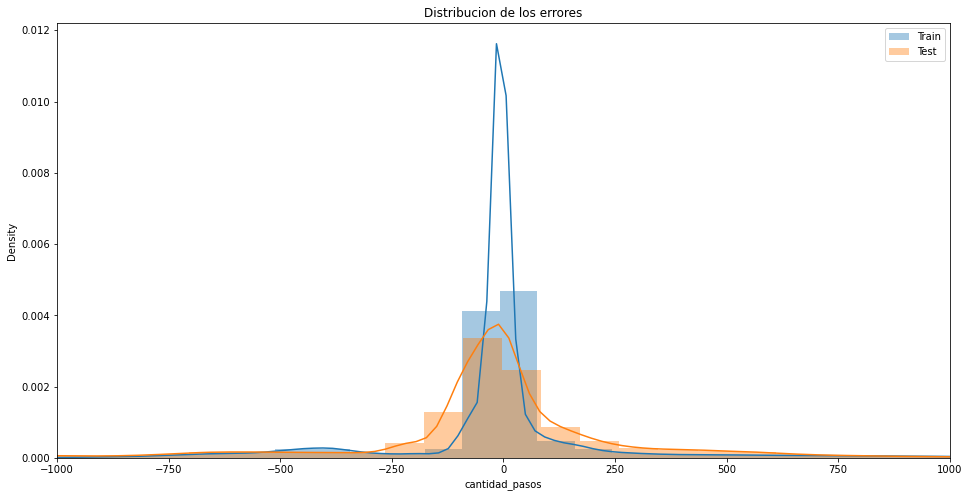

In [39]:
errores_train = y_train - y_train_pred
errores_test = y_test - y_test_pred

plt.figure(figsize = (16,8))
sns.distplot(errores_train, bins = 50, label = 'Train')
sns.distplot(errores_test, bins = 50, label = 'Test')

plt.xlim(-1000, 1000)

plt.title('Distribucion de los errores')
plt.legend()
plt.show()

Ademas de los buenos resultados obtenidos en las metrica elegida (RMSE), se puede observar graficamente como la distribucion de los errores (en train y test) tiene una distribucion normal con una tendencia a 0, por lo que se concluye como exitoso la mejora en el modelo gracias a:
- La incorporacion de nuevos datos (demas estaciones y formas de pago).
- Incrementar el conjunto de campos que se utiliza para predecir, especialmente la inclusion de variables categoricas a traves de dummies.
- Reinventar el modelo, buscando predecir la cantidad de pasos por dia siendo mas especificos, por ejemplo, cuando se paga en efectivo, en cierta estacion, etc. , en vez de buscar predecir la totalidad de pasos en general por dia.